# Exploring the graph of Boosted Trees

In order to experiment with the graph of boosted trees, here I will build very simple classification problems and experiment to see how models will be trained to predict on them

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import sklearn as sk

import tensorflow as tf

import os
import shutil

import typing as tp

import datetime as dt

## Prepare logs directory

In [2]:
LOGS_BASE_DIR = os.path.join(os.path.abspath('.'), 'logs')

try: 
    os.mkdir(LOGS_BASE_DIR) # ok with already-exists errors
except FileExistsError:
    pass

## 1D classification problem

Text(0, 0.5, 'Y')

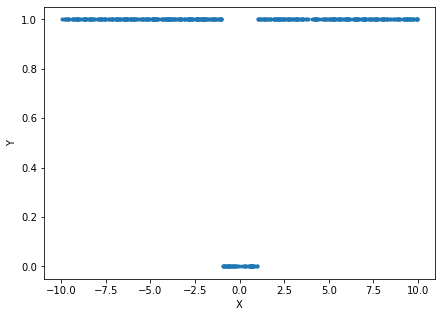

In [3]:
Y_CALC_FN = lambda x: x*x-1
Y_CLASSIFY_FN = lambda x: Y_CALC_FN(x)>0

X_TRAIN = (2*npr.random(500)-1)*10
Y_TRAIN = Y_CLASSIFY_FN(X_TRAIN)
#
X_TEST = (2*npr.random(500)-1)*10
Y_TEST = Y_CLASSIFY_FN(X_TEST)


#
fig, ax = pp.subplots(figsize=(7, 5))
ax.plot(X_TRAIN, Y_TRAIN, '.')
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Model prep

### Feature spec

In [4]:
FEATURE_COLUMNS = [
    tf.feature_column.numeric_column(key='X', shape=(1,), dtype=tf.dtypes.float32)
]

### Data ingestion

In [5]:
def make_input_fn(
    X: np.array, 
    y: np.array, 
    repeat_count: tp.Optional[int]=1
)->tp.Callable[[], tf.data.Dataset]:
    """
    Take data from X and y, package into dataset with batches that include the 
    full dataset and set to repeat
    
    Will be fed to model trainer
    """
    
    ####
    def input_fn():
        dset = tf.data.Dataset.from_tensor_slices(({'X': X}, y))
        dset = dset.repeat(repeat_count)
        dset = dset.batch(len(X))
        
        return dset
    ####
    
    return input_fn

### prepare data ingestion functions
TRAIN_INPUT_FN = make_input_fn(X_TRAIN, Y_TRAIN, repeat_count=None)
TEST_INPUT_FN = make_input_fn(X_TEST, Y_TEST, repeat_count=1)

### Model training

Can also use profiler to check out the training on tensorboard

In [6]:
## BT estimator
BT_EST = tf.estimator.BoostedTreesClassifier(
    FEATURE_COLUMNS, 
    n_batches_per_layer=1,
    n_trees=3,
    max_depth=12
)

# train and record profile info
# access on tensorboard using ```tensorboard --logdir logs```
# may have to select the PROFILE setting in the web-api interface 
timestamp_str = dt.datetime.now().strftime('%Y_%m_%dT%H_%M_%S')
PROFILER_DIR = os.path.join(LOGS_BASE_DIR, f'profiler_{timestamp_str}')

tf.profiler.experimental.start(PROFILER_DIR)
#
with tf.profiler.experimental.Trace(f'simple_boosted_trees_train_{timestamp_str}'):
    BT_EST.train(TRAIN_INPUT_FN, max_steps=10)
#
tf.profiler.experimental.stop()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmph3ox0def', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and 

### Save model

Clean up if needed:

In [7]:
BT_MODEL_BASE_PATH = os.path.join(os.path.abspath('.'), 'bt_saved_model')
shutil.rmtree(BT_MODEL_BASE_PATH, ignore_errors=True)
os.mkdir(BT_MODEL_BASE_PATH)

Now save the model

In [8]:
# prepare feature spec suitable for tf.Example
FEATURE_SPEC_DICT = {
    fc.key: tf.io.FixedLenFeature(shape=fc.shape, dtype=fc.dtype, default_value=fc.default_value)
    for fc in FEATURE_COLUMNS
}

# prepare serving_input_receiver_fn to link serialized tf.example to tensors expected by the model
serving_input_receiver_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
    FEATURE_SPEC_DICT, #
    default_batch_size=None
)

# now ready to save the model
BT_MODEL_BASE_PATH = os.path.join(os.path.abspath('.'), 'bt_saved_model')
#
BT_MODEL_PATH = BT_EST.export_saved_model(
    export_dir_base=BT_MODEL_BASE_PATH,
    serving_input_receiver_fn=serving_input_receiver_fn
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']
INFO:tensorflow:Signatures INCLUDED in export for Regress: ['regression']
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from /tmp/tmph3ox0def/model.ckpt-10
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:SavedModel wri

### Load the model & look at the graph

In [9]:
LOADED_EST = tf.saved_model.load(BT_MODEL_PATH)

Define function to convert floats to example_pb2

In [10]:
def float_X_to_example_pb2(
     float_val: float,
     feat_name: tp.Optional[str]='X'
)->tf.train.Example:
    #
    return  tf.train.Example(features=tf.train.Features(
        feature={feat_name: tf.train.Feature(
                                float_list=tf.train.FloatList(value=[float_val])
        )}
    ))

Test predictions

In [11]:
example_pb2_list = [float_X_to_example_pb2(val).SerializeToString() for val in X_TEST] 

# test predictions
pred_res = LOADED_EST.signatures['predict'](tf.constant(example_pb2_list))
pred_res['probabilities'].numpy()[0, 1]

0.8137045

Examine graph

In [12]:
for i_op, op in enumerate(LOADED_EST.graph.get_operations()):
    print(op, '\n-------------------\n')
    break

name: "global_step/Initializer/zeros"
op: "Const"
attr {
  key: "_class"
  value {
    list {
      s: "loc:@global_step"
    }
  }
}
attr {
  key: "dtype"
  value {
    type: DT_INT64
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT64
      tensor_shape {
      }
      int64_val: 0
    }
  }
}
 
-------------------



alternative

In [13]:
for i_op, op in enumerate(LOADED_EST.signatures['predict'].graph.get_operations()):
    print(op, '\n-------------------\n')
    break

name: "global_step"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_RESOURCE
  }
}
attr {
  key: "shape"
  value {
    shape {
    }
  }
}
 
-------------------



Can't go much further than that, internet searches lead to some protobufs for the key operations. Most likely would have to dig C++ code for it. Does not seem to be good documentation for it :-(

### Tensorboard

Can also produce logs suitable for tensorboard

In [14]:
# Set up logging.
timestamp_str = dt.datetime.now().strftime('%Y_%m_%dT%H_%M_%S')
TB_LOGDIR = os.path.join(LOGS_BASE_DIR, f'summary_{timestamp_str}')
summary_writer = tf.summary.create_file_writer(TB_LOGDIR)

# seem to need a function for graph to be built
@tf.function
def pred_call(pred_on):
    return LOADED_EST.signatures['predict'](pred_on)['probabilities']


# bracket the function call with trace_on & trace_off to read the graph
tf.summary.trace_off()
tf.summary.trace_on(graph=True, profiler=True)
# Call only one tf.function when tracing.
pred_call(tf.constant(example_pb2_list))

# record the trace int the log-dir that can be then presented to tensorboard
# since the top-level of the `logdir` is 'logs' it is sufficient
# to call (assuming in the current directory)
#    ```
#    tensorboard --logdir=logs
#    ````
#
with summary_writer.as_default():
  tf.summary.trace_export(
      name="simplified_bt_model",
      step=0,
      profiler_outdir=TB_LOGDIR)
tf.summary.trace_off()

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
use `tf.profiler.experimental.start` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
